In [1]:
import os
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from skimage.measure import compare_ssim
from scipy.stats import pearsonr
from keras import backend as K


#Read images from folder path specified in 'folder'
def read_dataset(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename),0)
        
        if img is not None:
            img = cv2.resize(img,(64,64))
            images.append(img)
    return images

Using TensorFlow backend.


In [2]:

import skimage
from sklearn.metrics import mean_squared_error
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means
from skimage.measure import compare_ssim as ssim
from random import shuffle
from keras.models import model_from_json

In [3]:
from keras.layers import *
from keras.models import Model
from keras import regularizers
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.core import Lambda

In [4]:
def read_all_datasets():
    rawimages = read_dataset('data/all-mias/')
    return np.array(rawimages)

In [5]:

rawimages = read_all_datasets()
rawimages.shape

(322, 64, 64)

In [6]:

#preprocessing
#rawimages = rawimages.astype('float32')/255.
images = np.reshape(rawimages, (rawimages.shape[0],64,64,1))

In [7]:
for index in range(rawimages.shape[0]):
    cv2.imwrite('./data/Test/denoise/image'+str(index)+'.png',rawimages[index])

In [8]:
#Function to add gaussian noise
def gaussian_noise(images,mean,sigma,prop):
    
    noisy_images = []
    for img in images:
        noisy_images.append(skimage.util.random_noise(img, mode='gaussian', seed=None, clip=True, mean=mean, var=sigma**2))
   
    return noisy_images

#Adding noise to images
def add_noise(images):
    #x_train = np.reshape(x_train, (len(x_train), 64*64))  # adapt this if using `channels_first` image data format
    #x_test = np.reshape(x_test, (len(x_test), 64*64))  # adapt this if using `channels_first` image data format
    batch = images.shape[0]//4;
    noise1 = gaussian_noise(images[0:batch],0,25,0.1)
    noise2 = gaussian_noise(images[batch:2*batch],0,30,0.5)
    noise3 = gaussian_noise(images[2*batch:3*batch],0,35,0.2)
    noise4 = gaussian_noise(images[3*batch:],0,40,0.2)
    
    noisy_set = []
    for data in [noise1,noise2,noise3,noise4]:  # data iterates through the list containing the noises
        for image in data:                      # for each element ie,image in the noise ie,data
            noisy_set.append(image)
    return np.array(noisy_set)

   # print("noise2=",noise2[1])
   # print("image=" ,image.size)
    
    
#Shuffle the noisy image ground truth pair to randomize the noise distribution in the dataset
def pair_shuffle(images,noisy_set):
    image_pair = []
    for i in range(images.shape[0]):
        image_pair.append((images[i],noisy_set[i]))
    shuffle(image_pair)
    
    ground_truth=[]
    noisy_images = []
    for i in range(images.shape[0]):
        ground_truth.append(image_pair[i][0])
        noisy_images.append(image_pair[i][1])
    return np.array(ground_truth), np.array(noisy_images)

In [9]:
#Shuffling and adding noise to the dataset
shuffle(images)
#Getting the noisy image set
noisy_set = add_noise(images)  # images is the actual dataset
ground_truth,noisy_images = pair_shuffle(images,noisy_set)

In [47]:
#Split into training and cross validation
train_size = int(ground_truth.shape[0]*0.8)
x_train = ground_truth[0:train_size]/255.
x_train_noisy = noisy_images[0:train_size]/255.
x_test = ground_truth[train_size:]/255.
x_test_noisy = noisy_images[train_size:]/255.
print(x_train_noisy.shape)
print(x_test_noisy.shape)

(257, 64, 64, 1)
(65, 64, 64, 1)


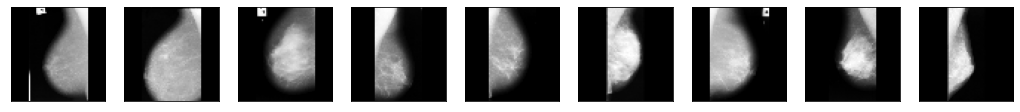

In [50]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
for index in range(x_train_noisy.shape[0]):
    cv2.imwrite('./data/Test/denoise/image'+str(index)+'.png',x_train_noisy[index]*255.)

In [12]:
for index in range(x_test_noisy.shape[0]):
    cv2.imwrite('./data/Test/gd/image'+str(index)+'.png',x_test_noisy[index]*255.)

In [13]:
#Defining the model

def get_simple_autoencoder_model(model_path=None):
    
    if(model_path is None):
        autoencoder = None
    else:
        autoencoder = read_model_json(model_path) 
    
    if(autoencoder is None):
        input_img = Input(shape=x_train_noisy[0].shape)  # adapt this if using `channels_last` image data format
                                                        #shape of 1st image in x_train_noisy
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy',metrics = ['accuracy'])

    print (autoencoder.summary())
    return autoencoder

In [21]:
model_checkpoint = ModelCheckpoint('./models/simple_cnn_autoencoder.hdf5',monitor = 'loss', verbose = 1,save_best_only=True)#verbose 0=silent,1=progress bar
tensorboard --logdir=/tmp/autoencoder

In [27]:
#Training the model
autoencoder = get_simple_autoencoder_model()
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir="/tmp/autoencoder/", histogram_freq=0, write_graph=True,profile_batch = 100000000),model_checkpoint])

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_21 (UpSampling (None, 32, 32, 64)        0  

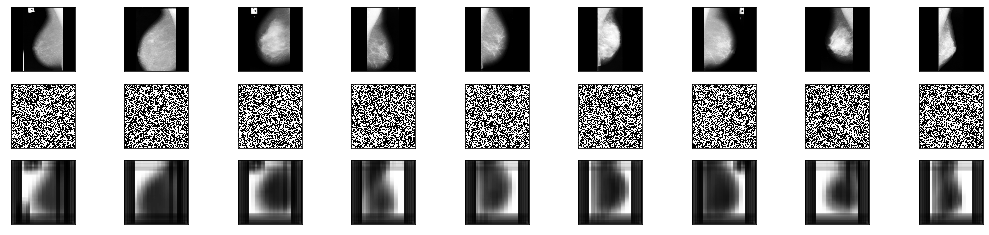

In [46]:
# plt.figure()

# #subplot(r,c) provide the no. of rows and columns
# f, axarr = plt.subplots(1,4) 
# decoded_imgs = autoencoder.predict(x_test)
# # use the created array to output your multiple images. In this case I have stacked 4 images vertically
# axarr[0].imshow(decoded_imgs[0].reshape(64,64))
# axarr[1].imshow(decoded_imgs[1].reshape(64,64))
# axarr[2].imshow(decoded_imgs[2].reshape(64,64))
# axarr[3].imshow(decoded_imgs[3].reshape(64,64))

decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,10):
    # display original
    ax = plt.subplot(3, n, i )
    plt.imshow(x_test[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display noisy
    ax = plt.subplot(3, n, i+n)
    plt.imshow(x_test_noisy[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(64,64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.show()
